# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [2]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("simulation/data/traj1M.txt", "rb"), delimiter=",")
# traj = np.loadtxt(open("simulation/data/traj_random100k.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_with_angs_1M.txt", "rb"), delimiter=",")


trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos_with_angs_1M.txt", "rb"), delimiter=",")
# jointPos = np.loadtxt(open("simulation/data/jointPos_random100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [3]:
#find and fix errors in data (small number of trials had huge joint angles)
err = np.argwhere(np.abs(jointPos) > 200)
print(err)

for i in err[:,0]:
    print(jointPos[i])
    jointPos[i] = jointPos[int(np.floor(np.random.rand()*np.shape(jointPos)[0]))]

print(jointPos[17336])

[[ 17336      0]
 [ 17336      1]
 [ 17336      2]
 [ 17336      3]
 [ 17336      4]
 [ 17336      5]
 [ 17336      6]
 [202354      3]
 [202354      4]
 [202354      5]
 [202354      6]
 [738713      0]
 [738713      1]
 [738713      2]
 [738713      3]
 [738713      4]
 [738713      5]
 [738713      6]]
[  19873.  -103340.   -31531.  1601800.     5992.9 1787200.  1959500. ]
[  2.2016   9.0002   1.8013 -11.052  -21.207  -19.891  -60.938 ]
[ -5.4268   3.6844  -4.7108  17.79    27.855   29.911  -94.021 ]
[ -9.055    8.6218   3.5242 -23.774   55.622   59.954  -67.667 ]
[  4.5408  -2.2205  -2.9486  -5.851   57.234   -8.6855 -41.957 ]
[  7.5781   1.8535   3.0295 -16.097  -21.918   19.466  -23.44  ]
[  7.8632    0.23486  -2.1774  -86.769   -19.389    -1.9782  -95.285  ]
[ -12.321    18.022     2.0468 -235.96    548.07    769.3    1437.2   ]
[  4.1578  -3.9599  -3.887  -22.833    7.4811   5.4503 -44.893 ]
[ -2.9936   9.058    1.2901 -89.477  -10.475   16.663  -63.564 ]
[  1.7739  -4.9588  -1

In [4]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 6, 1000000)
(1000000, 6, 10)
(1000000, 10, 6)


In [5]:
# from network import Net1 #optim for 1M linear dataset (not ideal because used inconsistant timesteps in solver)
# from network import Net2 #optim for 100k time varying
from network import Net3 #optim for data with position and rotation

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [6]:
# model = Net1()
model = Net3()

runLen = 30    

def scheduler(epoch, lr):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr
    
#     if epoch < part1:
#         lr = 0.001
#         return lr
#     if epoch >= part1 and epoch < part2:
#         lr = 0.0001
#         return lr
#     if epoch >= part2:
#         lr = 0.00001
#         return lr

#model1
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

#model 3 - test with absolute loss?
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr=0.001, clipvalue = 0.001),
# #     optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, clipvalue=1.0),
#     loss=tf.keras.losses.MeanSquaredError(),
#     metrics=[tf.keras.metrics.MeanSquaredError()],)


summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#for 1M linear dataset
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True) 
#New Changes- added 512 conv layer to network #Increases performance drastically (reaches val error of 89.0 in <30 epoch) 
#             adding another layer of 1024 (reaches val error of ~81.5 in <30 epoch)

# for 1M dataset with endpoint angles
trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)
#new changes: added 512 layers back in


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 6)        24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 8, 16)        304         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 8, 16)        784         conv1d[0][0]                     
_______________________________________________________________________________________

Epoch 1/30
7032/7032 [==============================] - 105s 15ms/step - loss: 294.0004 - mean_squared_error: 294.0004 - val_loss: 354.8600 - val_mean_squared_error: 354.8600
Epoch 2/30
7032/7032 [==============================] - 104s 15ms/step - loss: 215.5478 - mean_squared_error: 215.5478 - val_loss: 227.1226 - val_mean_squared_error: 227.1226
Epoch 3/30
7032/7032 [==============================] - 104s 15ms/step - loss: 166.3030 - mean_squared_error: 166.3030 - val_loss: 170.8068 - val_mean_squared_error: 170.8068
Epoch 4/30
7032/7032 [==============================] - 104s 15ms/step - loss: 141.1358 - mean_squared_error: 141.1358 - val_loss: 155.9720 - val_mean_squared_error: 155.9720
Epoch 5/30
7032/7032 [==============================] - 104s 15ms/step - loss: 122.4008 - mean_squared_error: 122.4008 - val_loss: 136.1148 - val_mean_squared_error: 136.1148
Epoch 6/30
7032/7032 [==============================] - 103s 15ms/step - loss: 107.3470 - mean_squared_error: 107.3470 - val_

(10.0, 500.0)

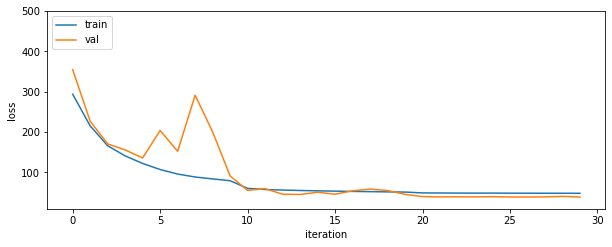

In [7]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,500)

In [ ]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

#from train data (not ideal to use for testing)
# prediction = model.predict(x_train[-1000:-1])
# actual = y_train[-1000:-1]

#x_data------------------
# just cart
# trajTest = np.loadtxt(open("simulation/data/traj_2sec.txt", "rb"), delimiter=",")
# trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
# numTrajTest = np.shape(trajTest)[1]//3 #number of test trajectories
# tTest = np.zeros([trajPtsTest,3,numTrajTest])
# for j in range(np.shape(trajTest)[0]):
#     for i in range(np.shape(trajTest)[1]//3):
#         tTest[j,:,i] = trajTest[j,3*i:3*(i+1)]

#cat + angs
trajTest = np.loadtxt(open("simulation/data/traj_with_angs_1k.txt", "rb"), delimiter=",")
trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
numTrajTest = np.shape(trajTest)[1]//6 #number of test trajectories
tTest = np.zeros([trajPtsTest,6,numTrajTest])
for j in range(np.shape(trajTest)[0]):
    for i in range(np.shape(trajTest)[1]//6):
        tTest[j,:,i] = trajTest[j,6*i:6*(i+1)]


        
#swap axis so batch size is first axis (for TF)
tTest = np.swapaxes(tTest,0,2)
#swap axis again so that conv1D moves on time and not xyz
tTest = np.swapaxes(tTest,1,2)
x_test = tf.convert_to_tensor(tTest,np.float32)

#y_data-------------------
# jointPosTest = np.loadtxt(open("simulation/data/jointPos_2sec.txt", "rb"), delimiter=",")
jointPosTest = np.loadtxt(open("simulation/data/jointPos_with_angs_1k.txt", "rb"), delimiter=",")
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = (y_test - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

#current best for network 1 is: 
#                 0.438 @ [0.09  0.082 0.034 0.086 0.061 0.024 0.058]
#                 val_error: 81.84

#current best for network 3 is: 
#                 0.357 @ [0.087 0.08  0.036 0.053 0.03  0.019 0.047]
#                 val_error: 44.97 
#                 (using 100k dataset)

print(prediction[-10])
print(y_test[-10])

In [ ]:
# model.save("trajectory_cls.kmod")

# model.save("trajectory_random_forces_cls.kmod")

model.save("trajectory_with_angs.kmod")

In [ ]:
#load best scoring model for 1M dataset
# model = tf.keras.models.load_model("trajectory_cls.kmod")

model = tf.keras.models.load_model("trajectory_with_angs.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint